In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

# **Загрузка данных:**

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')


train = pd.read_csv('./train.csv')
test= pd.read_csv('./test.csv')

In [ ]:
# списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Воспользуемся функцией info и посмотрим какой тип данных иммеет каждая колонка

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Посмотрим на столбец TotalSpent и можно видеть, что данный столбец имеет тип данных object, это говорит нам, что наши значения в столбце принимают разные типы данных


In [ ]:
train["TotalSpent"] = pd.to_numeric(train["TotalSpent"], errors='coerce').fillna(0)

In [ ]:
for col in train.columns:
  if train[col].dtypes=="object":
    train[col] = pd.to_numeric(train[col], errors='coerce').fillna(0)

Еще раз проверим какой тип имеет наши колонки с помощью функции info

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [ ]:
train.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

# **Анализ данных:**

Для численных призанков постройте гистограмму 

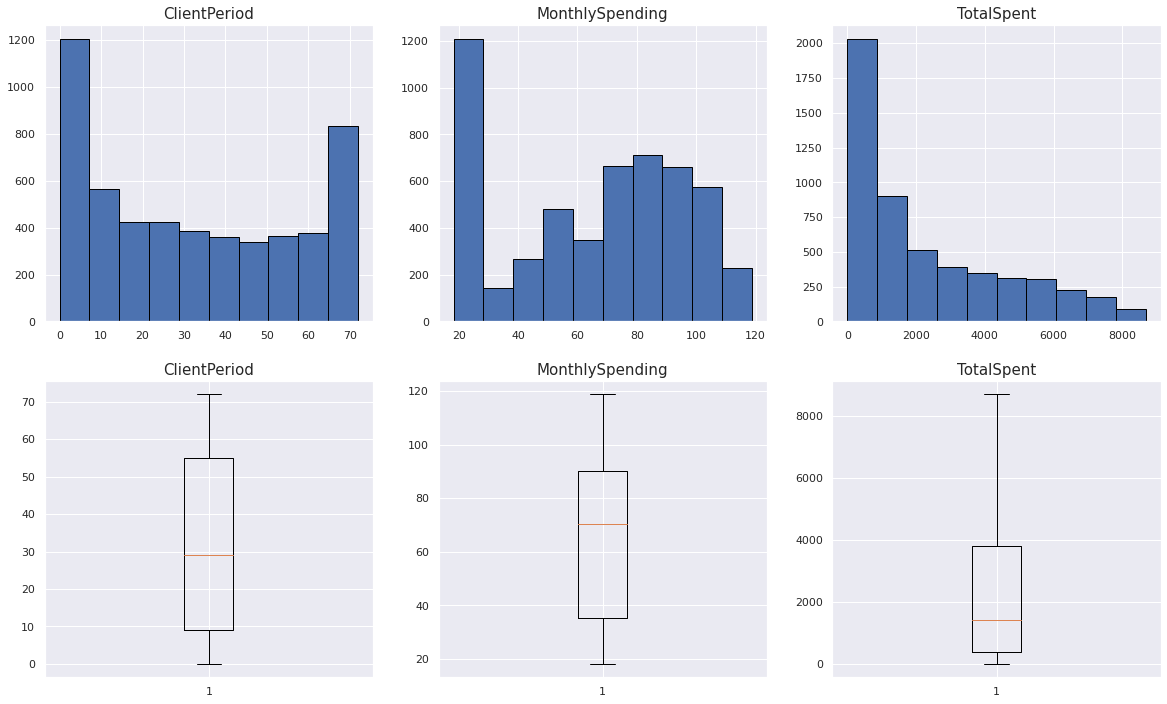

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
axs = axs.ravel()
for i, col in enumerate(num_cols):
    axs[i].hist(train[col],edgecolor = "black")
    axs[i].set_title(col).set_fontsize(15)
    axs[i+3].boxplot(train[col])
    axs[i+3].set_title(col).set_fontsize(15)

Для категориальных посчитаем количество каждого значения для каждого признака. 

In [ ]:
for col in cat_cols: 
  print("Colomn:",col)
  print(train[col].value_counts())
  print()

Colomn: Sex
Male      2655
Female    2627
Name: Sex, dtype: int64

Colomn: IsSeniorCitizen
0    4440
1     842
Name: IsSeniorCitizen, dtype: int64

Colomn: HasPartner
No     2705
Yes    2577
Name: HasPartner, dtype: int64

Colomn: HasChild
No     3676
Yes    1606
Name: HasChild, dtype: int64

Colomn: HasPhoneService
Yes    4761
No      521
Name: HasPhoneService, dtype: int64

Colomn: HasMultiplePhoneNumbers
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64

Colomn: HasInternetService
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64

Colomn: HasOnlineSecurityService
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64

Colomn: HasOnlineBackup
No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64

Colomn: HasDeviceProtection
No    

Для каждой колонки  построим круговые диаграммы  

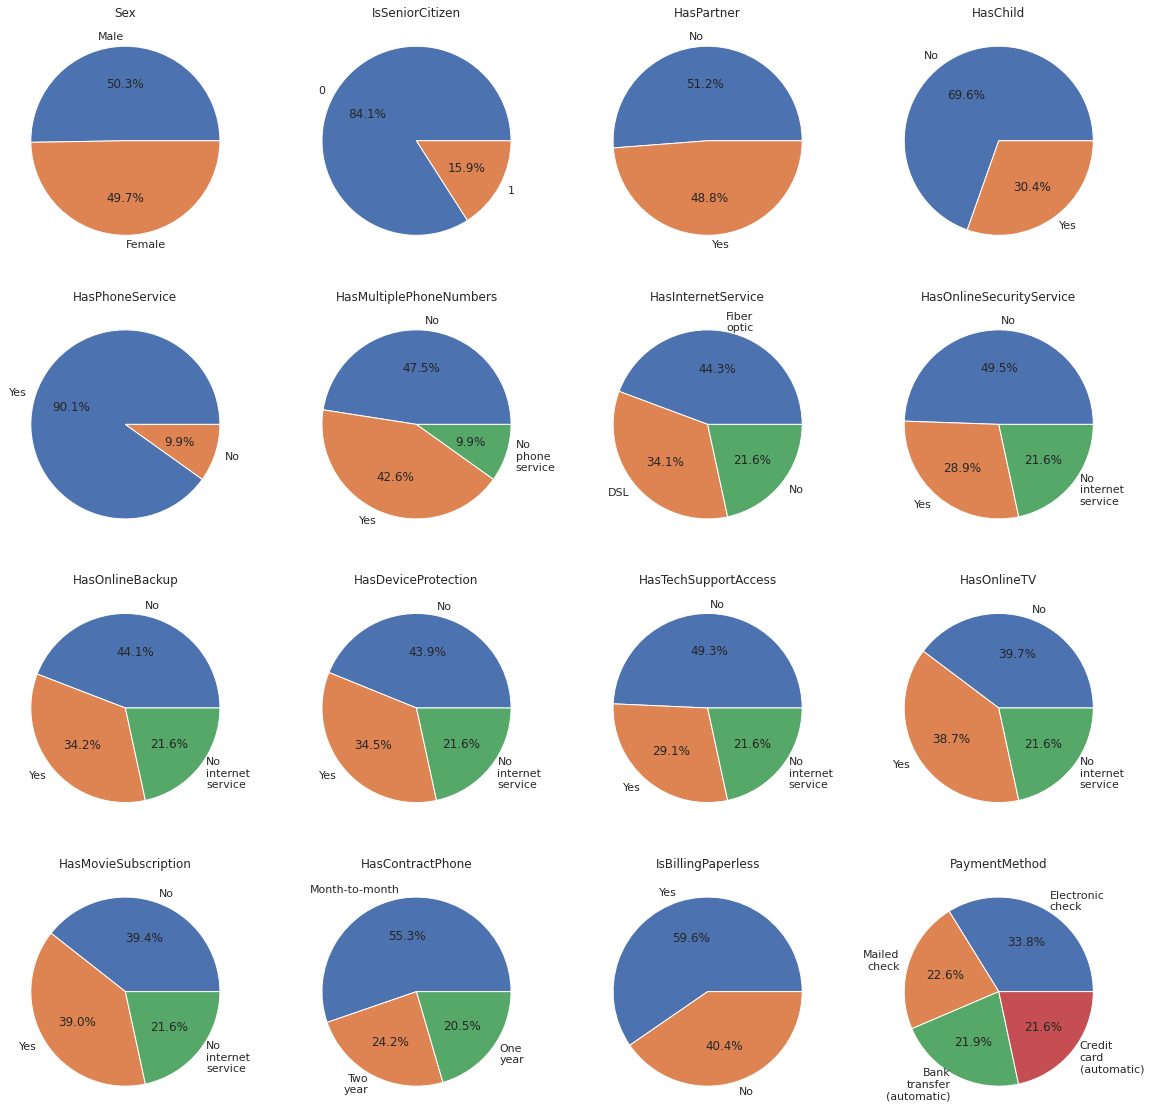

In [ ]:
fig,ax=plt.subplots(4,4,figsize=(20,20))
                    
ax = ax.ravel()
                    
for i, column in enumerate(cat_cols):
    serie = train[column].value_counts()
    labels = list(serie.index)
    values = list(serie)
    ax[i].set_title(column)
    ax[i].pie(values,
              labels=[str(s).replace(' ', '\n') for s in labels],
              autopct='%1.1f%%')
plt.show()

 Построим распределение целевой переменной 

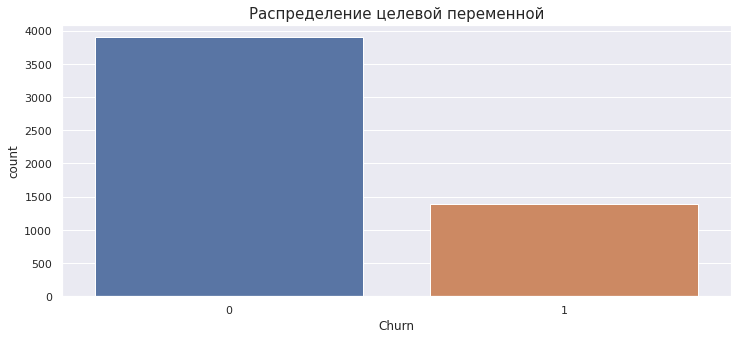

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(train[target_col]) 
plt.title('Распределение целевой переменной').set_fontsize(15)

Классы являются несбалансированными,так класс 0 на много больше класса 1

## **Применение линейных моделей:**

In [ ]:
y_train = train[target_col]
X_train = train.drop(target_col, axis=1)

Нормируем  числовые признаки и категориальные закодируем с помощью one-hot-encoding'а.

In [ ]:
prep_pipeline = ColumnTransformer([('num', StandardScaler(), num_cols),('cat', OneHotEncoder(sparse=False), cat_cols)])

In [ ]:
cls = make_pipeline(
    prep_pipeline,
    LogisticRegression(random_state=42, solver="saga", max_iter=10000)
    )

In [ ]:
param_grid = {
    'logisticregression__penalty' : ['l1', 'l2', 'elasticnet', None],
    'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001],
    'logisticregression__class_weight': ['balanced', None]
}

протестируем выборку для разных значениий гиперпараметра C

In [ ]:
model = GridSearchCV(cls, param_grid, cv=5, verbose=0, scoring='roc_auc', refit=True, n_jobs=-1)

In [ ]:
# обучаем модель
model.fit(X_train, y_train)

# смотрим лучше параметры
print("Best ROC-AUC metric:", round(model.best_score_,4))
print("Best estimator's parameters:", model.best_params_)

Best ROC-AUC metric: 0.8451
Best estimator's parameters: {'logisticregression__C': 100, 'logisticregression__class_weight': None, 'logisticregression__penalty': 'l1'}


# **Применение градиентного бустинга:**

In [ ]:
model.best_estimator_[1]

LogisticRegression(C=100, max_iter=10000, penalty='l1', random_state=42,
                   solver='saga')

In [ ]:
X_train_none, X_valid_none, y_train_none, y_valid_none = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
cb_none = CatBoostClassifier()
cb_none.fit(X_train_none, y_train_none, eval_set=(X_valid_none, y_valid_none),cat_features=cat_cols, verbose=250)

Learning rate set to 0.045236
0:	learn: 0.6622840	test: 0.6638133	best: 0.6638133 (0)	total: 65.1ms	remaining: 1m 4s
250:	learn: 0.3458988	test: 0.4313900	best: 0.4302981 (187)	total: 3.63s	remaining: 10.8s
500:	learn: 0.2995001	test: 0.4426834	best: 0.4302981 (187)	total: 7.52s	remaining: 7.49s
750:	learn: 0.2616903	test: 0.4493932	best: 0.4302981 (187)	total: 11.4s	remaining: 3.79s
999:	learn: 0.2305760	test: 0.4573436	best: 0.4302981 (187)	total: 15.4s	remaining: 0us

bestTest = 0.430298102
bestIteration = 187

Shrink model to first 188 iterations.


In [ ]:
preds = cb_none.predict_proba(X_valid_none)[:,1]
roc_auc_score(y_valid_none, preds)

0.828497150931373

In [ ]:
cb_model = CatBoostClassifier(
    loss_function='Logloss',
    cat_features=cat_cols,
    random_seed = 42,
    eval_metric='AUC',
    verbose=False)

In [ ]:
# cb_model.grid_search({'l2_leaf_reg': np.linspace(4, 5, 5),
#                       'max_depth': [3],
#                       'n_estimators': [200, 300, 400],
#                       'learning_rate': np.linspace(0.01, 0.2, 10)},
#                      X_train,
#                      y_train,
#                      cv=3,
#                      refit=True,
#                      verbose=False)

In [ ]:
best_cb_model = CatBoostClassifier(
    depth=3,
    iterations=200,
    eval_metric='AUC',
    l2_leaf_reg=4.25,
    learning_rate=0.052222222222222225,
    loss_function='Logloss',
    cat_features=cat_cols,
    random_seed=42,
    verbose=200)

In [ ]:
best_cb_model.fit(X_train, y_train)

0:	total: 8.71ms	remaining: 1.73s
199:	total: 1.57s	remaining: 0us


In [ ]:
pred_train = best_cb_model.predict_proba(X_train)[:,1]
roc_auc_score(y_train, pred_train)

0.8564638342769525

лучшее качество состовляет 0.85 

# **Предсказания:**

In [ ]:
X_test = pd.read_csv('./test.csv')
submission=pd.read_csv('./submission.csv')
submission['Churn']=best_cb_model.predict_proba(test)[:,1]
submission.to_csv('./submission.csv',index=False)
submission



,Id,Churn
0,0,0.037553
1,1,0.659613
2,2,0.615803
3,3,0.016142
4,4,0.007408
...,...,...
1756,1756,0.141629
1757,1757,0.016034
1758,1758,0.769069
1759,1759,0.474372


In [ ]:
from google.colab import files

In [ ]:
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>